In [ ]:
!pip install --no-cache-dir imageio

In [20]:
from __future__ import absolute_import, division, print_function, unicode_literals
import tensorflow as tf
print(tf.__version__)

import glob
import imageio
import matplotlib.pyplot as plt
import numpy as np
import os
import PIL
from tensorflow.keras import layers
import time
import datetime

from scipy.ndimage.filters import gaussian_filter

from IPython import display

2.1.0


In [21]:
IMG_HEIGHT = 256
IMG_WIDTH = 256
noise_dim = 100

In [76]:
def showImage(image):
    fig = plt.figure(figsize=(15,15))

    plt.subplot(1,2,1)
    plt.imshow(image[:, :, 0], cmap='gray', vmin=-1, vmax=1)
    plt.subplot(1,2,2)
    plt.imshow(image[:, :, 1:]/2+0.5)
    plt.show()
    
def saveImage(image, id, name, gauss=True):
    gs = image[:, :, 0]
    if gauss:
        gs = gaussian_filter(gs, sigma=1)
    
    rgb = ((gs * 5000 + 20000)*10).astype(int)
    b = rgb & 0xff
    g = (rgb >> 8) & 0xff
    r = (rgb >> 16) & 0xff
    
    imageio.imwrite('./'+id+'/'+name+'_rgb.png', np.stack((r,g,b), axis=2)) 
    imageio.imwrite('./'+id+'/'+name+'_gs.png', gs/2+0.5)
    imageio.imwrite('./'+id+'/'+name+'_tex.png', image[:, :, 1:]/2+0.5)

In [ ]:
anim_file = run_id+'/dcgan.gif'

with imageio.get_writer(anim_file, mode='I') as writer:
  filenames = glob.glob(run_id+'/image*.png')
  filenames = sorted(filenames)
  last = -1
  for i,filename in enumerate(filenames):
    frame = 2*(i**0.5)
    if round(frame) > round(last):
      last = frame
    #else:
      #continue
    image = imageio.imread(filename)
    writer.append_data(image)
  image = imageio.imread(filename)
  writer.append_data(image)

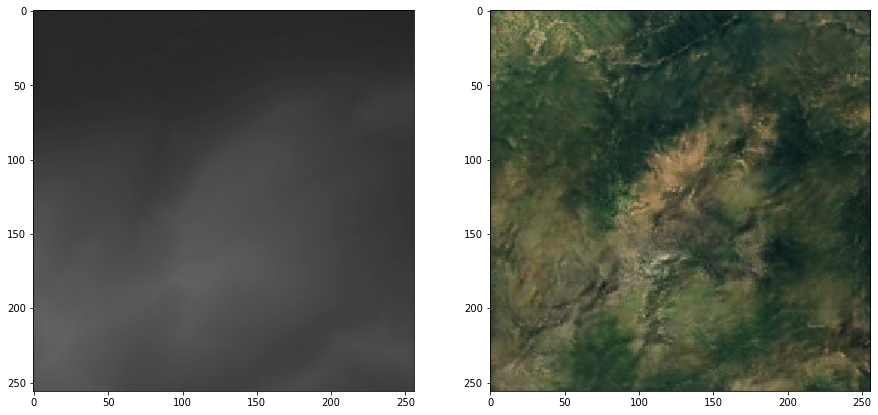

Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


In [8]:
run_id = '20200405-115308'
g = tf.keras.models.load_model('./'+run_id+'/generator/')
#d = tf.keras.models.load_model('./'+run_id+'/discriminator/')

#cp = tf.train.Checkpoint(generator=g,discriminator=d)
cp = tf.train.Checkpoint(generator=g)

checkpoint_dir = './'+run_id+'/training_checkpoints'
cp.restore(tf.train.latest_checkpoint(checkpoint_dir))

noise = tf.random.normal([1, noise_dim])
#noise = tf.ones_like(noise)
generated_image = g(noise, training=False)

showImage(generated_image[0])
#plt.imshow(generated_image[0, :, :, 0], cmap='gray', vmin=-1, vmax=1)
imageio.imwrite('./'+run_id+'/sample.png', generated_image[0, :, :, 0]/2+0.5)
#decision = d(generated_image)
#print (decision)

In [47]:
def lossX(prediction, target, offset=5, width=1, tex_weight=0.5):
    gs = tf.reduce_mean(tf.square(prediction[:,offset:offset+width,0] - target[:,-offset-width:-offset,0]))
    tex = tf.reduce_mean(tf.square(prediction[:,offset:offset+width,1:] - target[:,-offset-width:-offset,1:]))
    return gs*(1-tex_weight) + tex*tex_weight

def lossY(prediction, target, offset=5, width=1, tex_weight=0.5):
    gs = tf.reduce_mean(tf.square(prediction[offset:offset+width,:,0] - target[-offset-width:-offset,:,0]))
    tex = tf.reduce_mean(tf.square(prediction[offset:offset+width,:,1:] - target[-offset-width:-offset,:,1:]))
    return gs*(1-tex_weight) + tex*tex_weight

cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=False)

In [49]:
def createImage(targetX, targetY, iterations, offset, log, overlap, perception_weight, tex_weight):
    image = tf.Variable(tf.random.normal([1, noise_dim]))
    optimizer = tf.keras.optimizers.Adam(learning_rate=0.1)
    
    for iteration in range(iterations):
        with tf.GradientTape() as tape:
            tape.watch(image)
            
            pred = g(image, training=False)
            prediction = pred[0]
            
            if targetX is not None:
                if targetY is not None:
                    c_loss = lossX(prediction,targetX, offset, overlap, tex_weight)/2 + lossY(prediction,targetY, offset, overlap, tex_weight)/2
                else:
                    c_loss = lossX(prediction,targetX, offset, overlap, tex_weight)
            elif targetY is not None:
                c_loss = lossY(prediction,targetY, offset, overlap, tex_weight)
             
            p_loss = 0
            if perception_weight > 0:
                out = d(pred)
                p_loss = cross_entropy(tf.ones_like(out), out)
                loss_value = c_loss + 0.1*perception_weight*p_loss
            else:
                loss_value = c_loss

        #stop if loss is low enough
        if loss_value < 1e-4:
            break
        # Use the gradient tape to automatically retrieve
        # the gradients of the trainable variables with respect to the loss.
        grads = tape.gradient(loss_value, image)
        #print(grads)  # output: [None]
        optimizer.apply_gradients(zip([grads], [image]))

        display.clear_output(wait=True)
        print('{}: Iteration {}/{}: Loss {:.5f} (C:{:.5f} P:{:.5f})'.format(log, iteration+1, iterations, loss_value, c_loss, p_loss))
    return g(image, training=False)[0]

def smoothConcatX(img1, img2, width=10):
    v1 = img1[:,-1:]
    v2 = img2[:,0:1]
    mean = (v1+v2)/2.0
    blend = np.zeros(len(img1[0]))
    for i in range(1,width):
        blend[-i] = (width-i)/(width)
        
    blend2 = np.zeros(len(img2[0]))
    for i in range(1,width):
        blend2[i-1] = (width-i)/(width)
    
    corr1 = np.multiply(mean-v1, blend)
    corr2 = np.multiply(mean-v2, blend2)
    return tf.concat([img1+corr1, mean, img2+corr2], 1)

def overlapConcatX(img1, img2, width=10):
    v1 = img1[:,-width:]
    v2 = img2[:,:width]
    
    blend = np.zeros((1,width,1))
    for i in range(width):
        blend[0,i] = (i+1)/(width+1)
    
    corr = np.multiply(v1, 1-blend) + np.multiply(v2, blend)
    
    return tf.concat([img1[:,:-width], corr, img2[:,width:]], 1)

def smoothConcatY(img1, img2, width=10):
    v1 = img1[-1:,:]
    v2 = img2[:1,:]
    mean = (v1+v2)/2.0
    blend = np.zeros((len(img1),1))
    for i in range(1,width):
        blend[-i] = (width-i)/(width)
    
    blend2 = np.zeros((len(img2),1))
    for i in range(1,width):
        blend2[i-1] = (width-i)/(width)

    corr1 = np.multiply(mean-v1, blend)
    corr2 = np.multiply(mean-v2, blend2)
    return tf.concat([img1+corr1, mean, img2+corr2], 0)

def overlapConcatY(img1, img2, width=10):
    v1 = img1[-width:,:]
    v2 = img2[:width,:]
    
    blend = np.zeros((width,1,1))
    for i in range(width):
        blend[i] = (i+1)/(width+1)
    
    corr = np.multiply(v1, 1-blend) + np.multiply(v2, blend)
    
    return tf.concat([img1[:-width,:], corr, img2[width:,:]], 0)

def smoothConcatAllX(imgs, width, overlap):
    img1 = imgs[0]
    for i in range(1,len(imgs)):
        img2 = imgs[i]
        if overlap > 0:
            img1 = overlapConcatX(img1, img2, overlap)
        else:
            img1 = smoothConcatX(img1, img2, width)
    return img1

def smoothConcatAllY(imgs, width, overlap):
    img1 = imgs[0]
    for i in range(1,len(imgs)):
        img2 = imgs[i]
        if overlap > 0:
            img1 = overlapConcatY(img1, img2, overlap)
        else:
            img1 = smoothConcatY(img1, img2, width)
    return img1

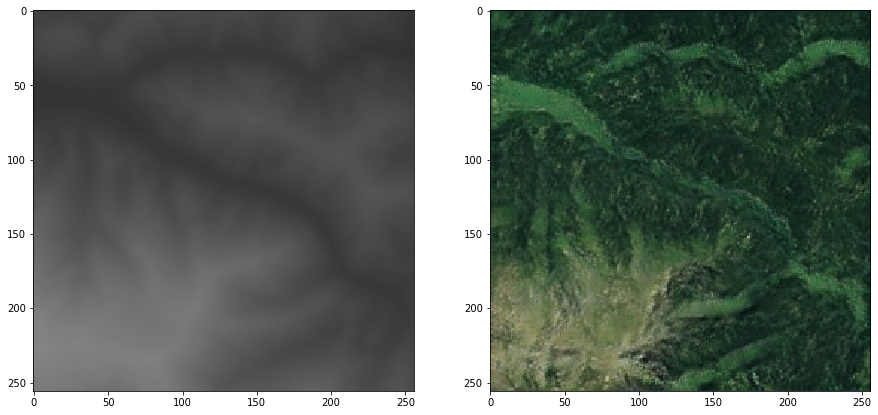

Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


In [18]:
generated_image = g(tf.random.normal([1, noise_dim]), training=False)
showImage(generated_image[0])
saveImage(generated_image[0], run_id, 'sample')

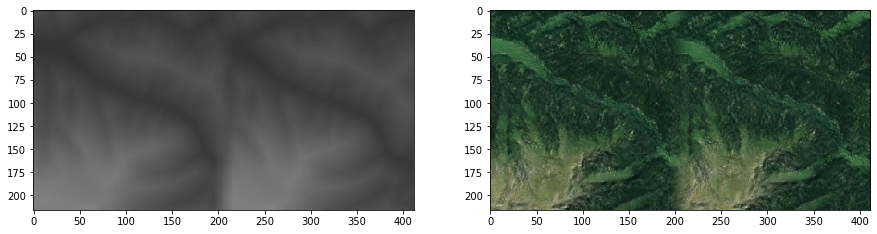

In [38]:
img = generated_image[0, OFFSET:-OFFSET,OFFSET:-OFFSET]
interp = overlapConcatX(img, img, 20)
showImage(interp)
#imageio.imwrite('./'+run_id+'/interp.png', interp/2+0.5)

Tile 48/48: Iteration 1000/1000: Loss 0.00795 (C:0.00795 P:0.00000)
Total time: 7604.206411361694 sec


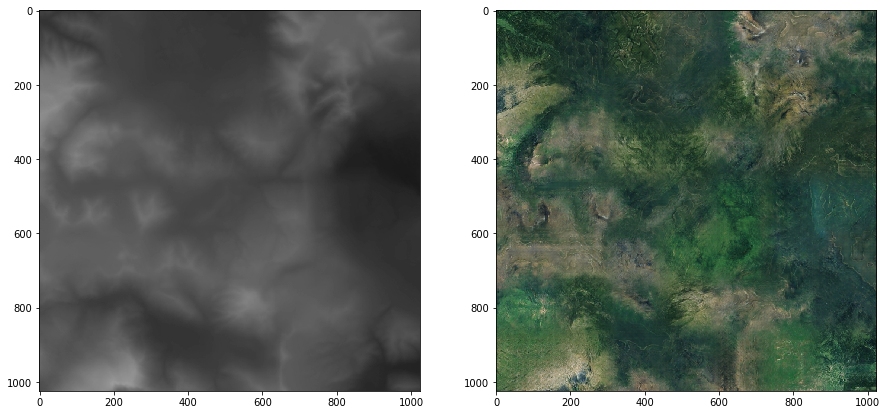

In [82]:
WIDTH = 7
HEIGHT = 7
N_ITER = 1000
OFFSET = 30
BLEND = 20
OVERLAP = 58
TEX_WEIGHT = 0.25
PERCEPTION_WEIGHT = 0

start = time.time()
total = WIDTH*HEIGHT-1
target = generated_image[0]
rows = []
row = [target[OFFSET:-OFFSET,OFFSET:-OFFSET]]
prev = [target]
print("starte")
for w in range(1, WIDTH):
    target = createImage(target, None, N_ITER, OFFSET, 'Tile {}/{}'.format(w, total), OVERLAP, PERCEPTION_WEIGHT, TEX_WEIGHT)
    prev.append(target)
    row.append(target[OFFSET:-OFFSET,OFFSET:-OFFSET])
rows.append(smoothConcatAllX(row, BLEND, OVERLAP))
    
for h in range(1, HEIGHT):
    target = createImage(None, prev[0], N_ITER, OFFSET, 'Tile {}/{}'.format(WIDTH*h, total), OVERLAP, PERCEPTION_WEIGHT, TEX_WEIGHT)
    row = [target[OFFSET:-OFFSET,OFFSET:-OFFSET]]
    curr = [target]
    for w in range(1, WIDTH):
        target = createImage(target, prev[w], N_ITER, OFFSET, 'Tile {}/{}'.format(WIDTH*h+w, total), OVERLAP, PERCEPTION_WEIGHT, TEX_WEIGHT)
        curr.append(target)
        row.append(target[OFFSET:-OFFSET,OFFSET:-OFFSET])
    prev = curr
    rows.append(smoothConcatAllX(row, BLEND, OVERLAP))

print('Total time: {} sec'.format(time.time()-start))
res = smoothConcatAllY(rows, BLEND, OVERLAP)

showImage(res)

In [83]:
saveImage(res, run_id, 'sample_2')

Lossy conversion from int32 to uint8. Range [0, 255]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
